# Campus Recruitment Analysis

## Introduction

The data from this analysis is from [kaggle Campus Recruit](https://www.kaggle.com/benroshan/factors-affecting-campus-placement), which contains 215 student data including their education level, degree, gender, specialization ect.

The purpose of this analysis is to analyze the data and build a classifier using machine learning techniques such as decision tree and random forest, logstic regression to classify the student status into being placed a job or not being placed a job. The analysis will use different classification techniques and compare which classifier make the best prediction for this dataset.

The second part of the analysis will perform a regression analysis using only the students that get job to find out some of the key factors that influence the salary of an offer. The analysis are performed in Python using Jupyter Notebook. Various techniques that are used in this analysis are:

- Explorary data analysis
- Random forest regressor and classifier
- Logstic regression classifier
- Multiple linear regression


## Loading data and libraries

The analysis starts with loading data and necessary library.


In [1]:
# Load necessary library
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import matplotlib.ticker as mtick
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn')
%matplotlib inline

# set default plot size
plt.rcParams["figure.figsize"] = (15,8)

## Data loading and cleanning

In [2]:
# Load and preview data 
recruit = pd.read_csv("/Users/leo/Personal/GitHub/Campus Recruitment Analysis/Placement_Data_Full_Class.csv")
recruit.head()

,sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
0,1,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed,270000.0
1,2,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed,200000.0
2,3,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed,250000.0
3,4,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed,NaN
4,5,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed,425000.0


In [3]:
# drop id column
recruit.drop('sl_no',axis=1,inplace=True)
recruit.shape

(215, 14)

In [4]:
# Summary Statistics
recruit.describe()

,ssc_p,hsc_p,degree_p,etest_p,mba_p,salary
count,215.000000,215.000000,215.000000,215.000000,215.000000,148.000000
mean,67.303395,66.333163,66.370186,72.100558,62.278186,288655.405405
std,10.827205,10.897509,7.358743,13.275956,5.833385,93457.452420
min,40.890000,37.000000,50.000000,50.000000,51.210000,200000.000000
25%,60.600000,60.900000,61.000000,60.000000,57.945000,240000.000000
50%,67.000000,65.000000,66.000000,71.000000,62.000000,265000.000000
75%,75.700000,73.000000,72.000000,83.500000,66.255000,300000.000000
max,89.400000,97.700000,91.000000,98.000000,77.890000,940000.000000


In [5]:
# Check each column for nas
recruit.isnull().sum()

gender             0
ssc_p              0
ssc_b              0
hsc_p              0
hsc_b              0
hsc_s              0
degree_p           0
degree_t           0
workex             0
etest_p            0
specialisation     0
mba_p              0
status             0
salary            67
dtype: int64

After we load the data, we can see that there are 215 observations and 14 columns in this dataset with a mix of categorical and numeric variables. The target variable for our classification problem is the **status** column, which is stored as **Placed** and **Not Placed**. There are other binary variables such as **gender**, **workex** need to transfer into 0 and 1 later in the analysis. Other categorical variables with multiple levels, we'll use *One Hot Encoding* to transfer to binary variables. Also, the first column **sl_no** will be dropped from the dataset as it's an index column.

By the first glance of the dataset, it's pretty clean. There's no missing values other that the salary for those who wasn't offered a job. Thus **salary** will be excluded in the first part of the analysis (Classification).

## Exploratory Data Analysis and Data Visualization

After we get the first look at the data, we'd like to get a better understanding by performing some EDA and data visualizations.

We first start with a pairplot from the `seaborn` library using `sns.pariplot()`. This will give us the correlation of all numeric variables in the dataset. We've also set `hue = 'status'` to see how the value distribute under different status. This can help us better identify variables later in the classifier.

From the plot, we can see that the following variables might be significantly different under different student status

- ssc_p: Secondary Education percentage- 10th Grade
- degree_p: Degree Percentage

Other variables shows different distribution under different status as well.

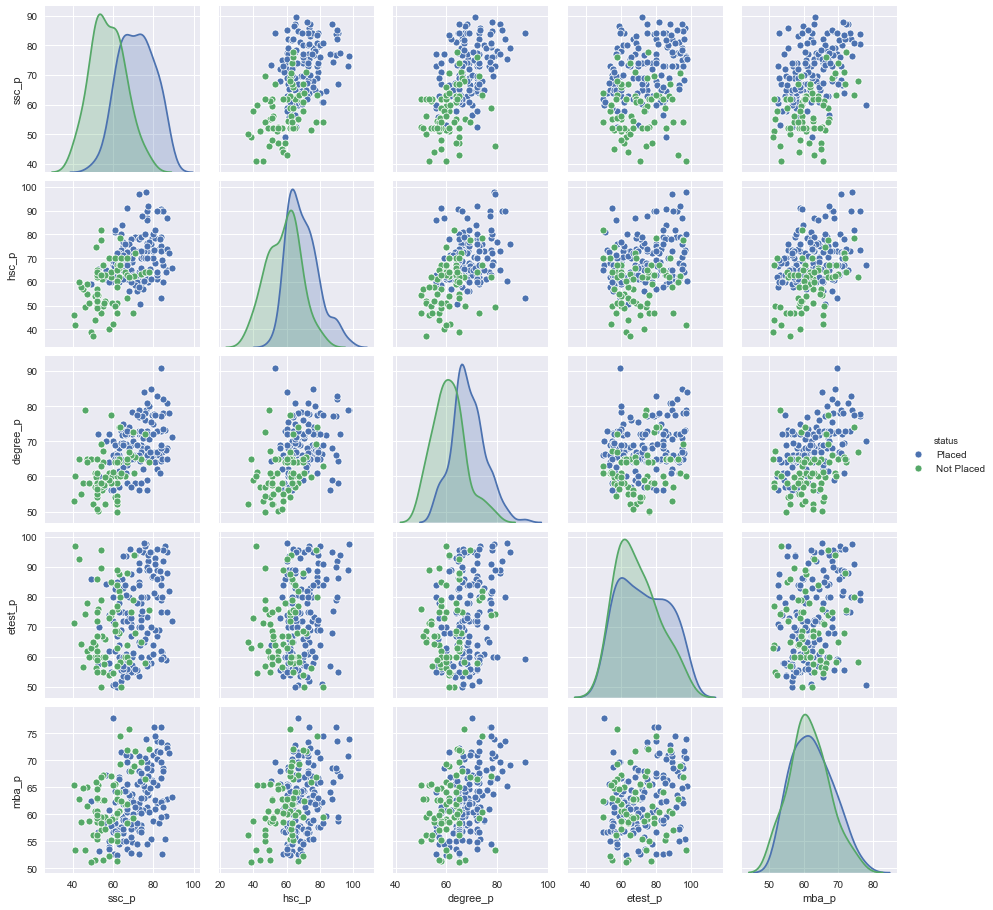

In [6]:
sns.pairplot(recruit.drop('salary',axis=1),hue = 'status')

# gender             0
# ssc_p              0
# ssc_b              0
# hsc_p              0
# hsc_b              0
# hsc_s              0
# degree_p           0
# degree_t           0
# workex             0
# etest_p            0
# specialisation     0
# mba_p              0
# status             0
# salary            67

We then want to see the student status by gender. From the table below and the barplot, we can see that more male students were placed a job then female.

In [7]:
recruit.groupby(["gender","status"]).size().unstack()

status,Not Placed,Placed
gender,,
F,28,48
M,39,100


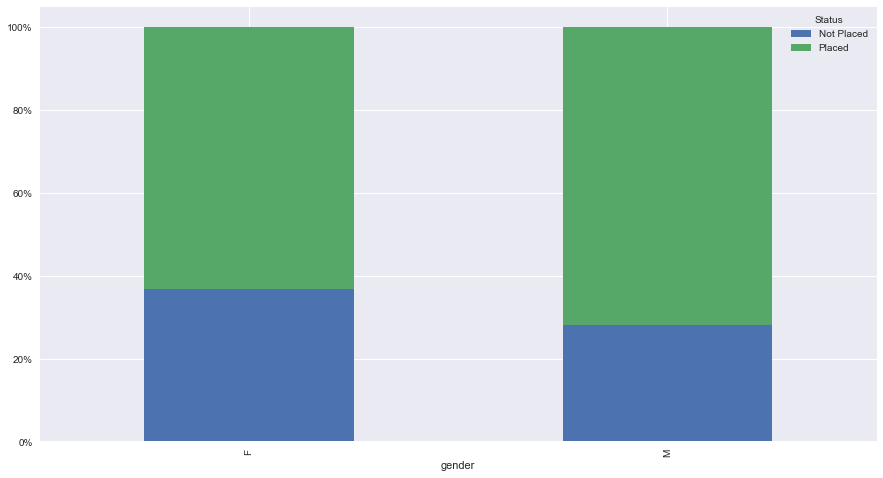

In [8]:
recruit.groupby(["gender","status"]).size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind='bar',stacked=True)

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(loc = 'upper right',title = 'Status')
plt.show()

# most of males are placed job than female

The following table shows the average of all the numeric variables under different status. We can see that other than **mba_p**, all the other variables have difference in mean

In [9]:
recruit.groupby('status').mean()

,ssc_p,hsc_p,degree_p,etest_p,mba_p,salary
status,,,,,,
Not Placed,57.544030,58.395522,61.134179,69.587910,61.612836,NaN
Placed,71.721486,69.926554,68.740541,73.238041,62.579392,288655.405405


To further examine the distribution of numeric variables under different groups, boxplots are useful. But first, we need to tranfer the dataset so that we can visualize all the numeric variables under one graph.

The first step is to extract all the numeric variables and then transfer the dataset from **wide** to **long** format using `pd.melt()` .

After that, we can plot the scatter plots. The scatter plot below shows the similiar information as what we see on the table, which is almost all variables have a higher value in the placed group than not placed group, while mba percent seem to have the least influence on whether a student is placed or not.

In [10]:
recruit_numeric = recruit[['ssc_p','hsc_p','degree_p','etest_p','mba_p','status']]

recruit_numeric_melt = pd.melt(recruit_numeric,id_vars='status',
                               value_vars =['ssc_p','hsc_p','degree_p','etest_p','mba_p'])
recruit_numeric_melt.head()

,status,variable,value
0,Placed,ssc_p,67.00
1,Placed,ssc_p,79.33
2,Placed,ssc_p,65.00
3,Not Placed,ssc_p,56.00
4,Placed,ssc_p,85.80


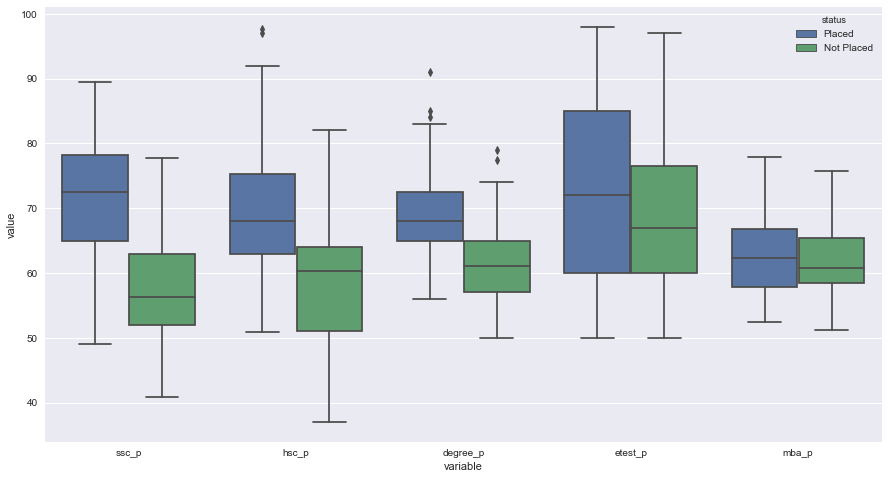

In [11]:
sns.boxplot(x="variable", y="value",
            hue="status", data=recruit_numeric_melt)

After we finished with the numeric variables, we proceeded with all the categorical variables. Applying the same approach for all the categorical variables, we used stacked barplot to see the count of observations in each group.

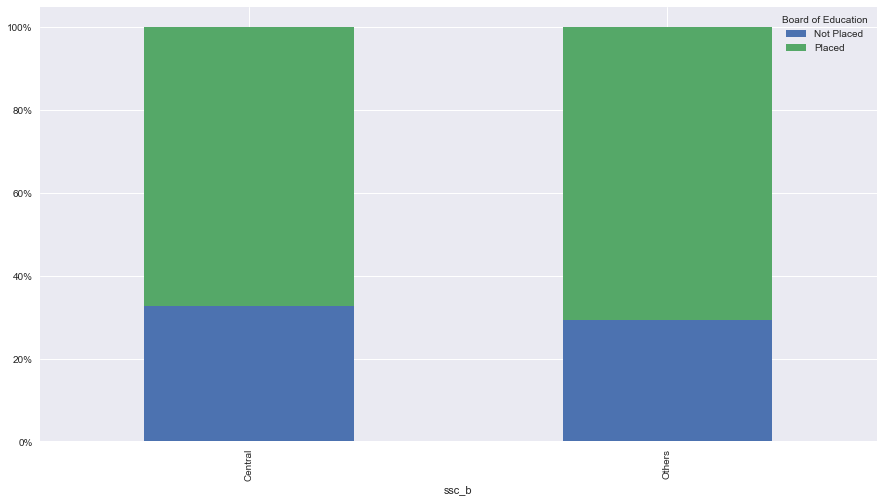

In [12]:
# then will look at all the categorical variables

# column description 
# ssc_b              Board of Education- Central/ Others
# hsc_b              Board of Education- Central/ Others
# hsc_s              Specialization in Higher Secondary Education
# degree_t           Under Graduation(Degree type)- Field of degree education
# workex             Work Experience
# specialisation     Post Graduation(MBA)- Specialization
# status             Status of placement- Placed/Not placed
# salary             Salary offered by corporate to candidates


# Board of Education - 10th grade
recruit.groupby(["ssc_b","status"]).size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind='bar',stacked=True)

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(loc = 'upper right',title = 'Board of Education')
plt.show()

# central and others almost no difference for secondary education board of education

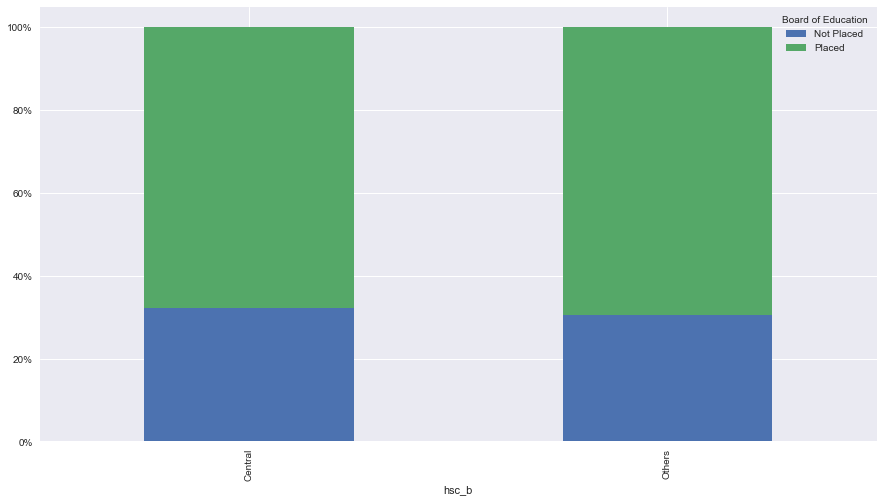

In [13]:
# Board of Education - 12th grade
recruit.groupby(["hsc_b","status"]).size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind='bar',stacked=True)

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(loc = 'upper right',title = 'Board of Education')
plt.show()

# similarly central and others almost no difference for secondary education board of education

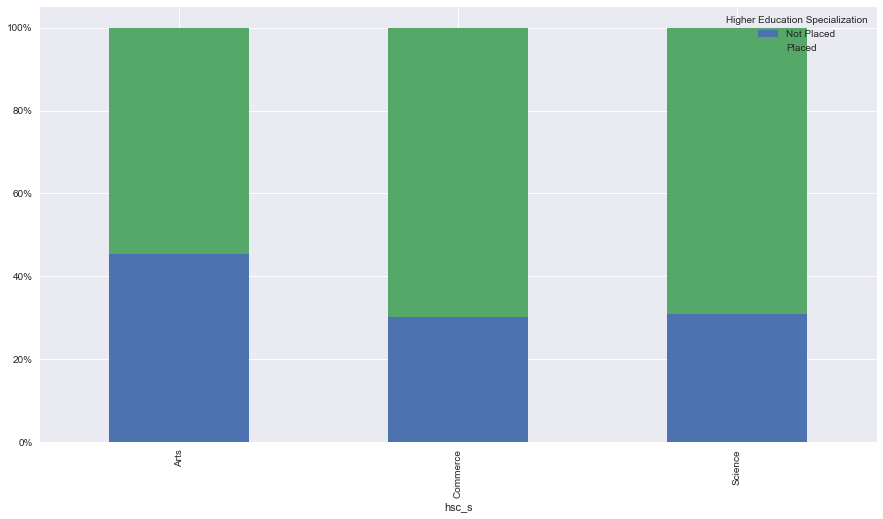

In [14]:
# Specialization in Higher Secondary Education
recruit.groupby(["hsc_s","status"]).size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind='bar',stacked=True)

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(loc = 'upper right',title = 'Higher Education Specialization')
plt.show()

# commerce and science are more likely to get placed

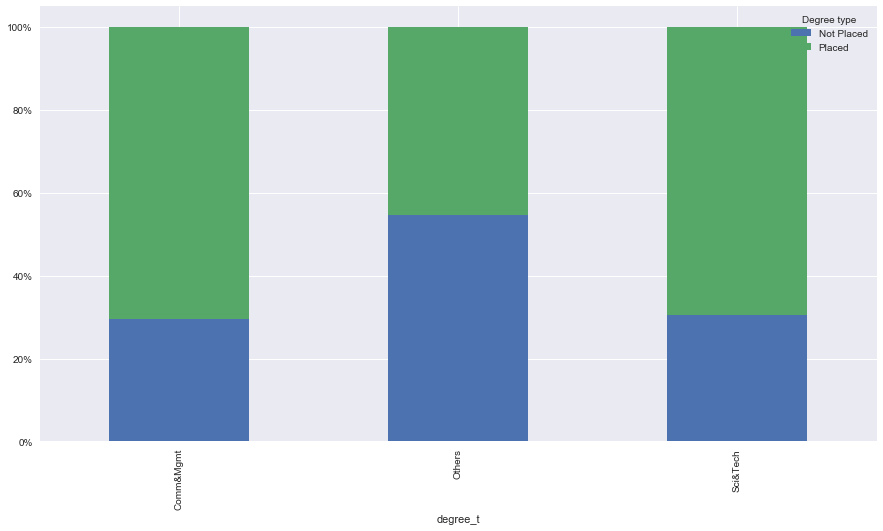

In [15]:
# Under Graduation(Degree type)- Field of degree education
recruit.groupby(["degree_t","status"]).size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind='bar',stacked=True)

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(loc = 'upper right',title = 'Degree type')
plt.show()

# for undergraduate degrees, comm/management and sci/tech are more likely to get placed

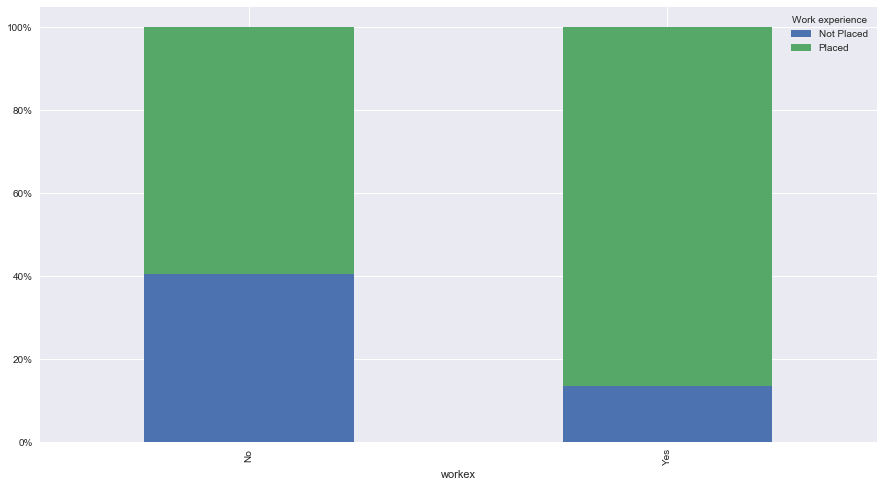

In [16]:
# Work Experience
recruit.groupby(["workex","status"]).size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind='bar',stacked=True)

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(loc = 'upper right',title = 'Work experience')
plt.show()

# having working experience is more likely to get placed and it has the most influence by comparing the graphs

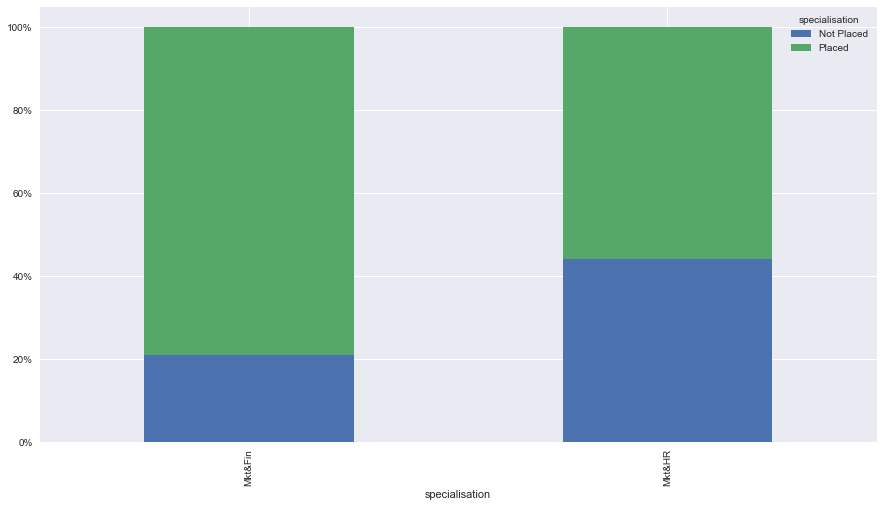

In [17]:
# Post Graduation(MBA)- Specialization
recruit.groupby(["specialisation","status"]).size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind='bar',stacked=True)

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(loc = 'upper right',title = 'specialisation')
plt.show()

# mrkt/finance are more likely to get placed than mrkt/hr

To sum up the information found on the plots above:

- Board of Education - 10th grade and 12th grade has less influence on status
- For secondary education, commerce and science are more likely to get placed
- For undergraduate degrees, comm/management and sci/tech are more likely to get placed
- Having working experience is more likely to get placed and it has the most influence by comparing the graphs
- For Post Graduation(MBA), mrkt/finance are more likely to get placed than mrkt/hr

This wrapped up EDA and data visualization.

The next step would be training classifier using random forest and logistic regression.

## Classification

### Random Forest Regressor and Classifier

Random forest is a powerful classifier in machine learning in that it can not only be used as a classifier, but also as a regressor. Random Forest also works well for small datasets, which made it the first choice of our classification problem.

As mentioned above, before training the model, we need to transform all of the categorical variables. For binary variables, we are transfering them into 0 and 1. For other multi class variables, we are transferring them using *One Hot Encoding* by using `pd.get_dummies` from the pandas library.


In [18]:
# transfer categorical vaeiables to dummy variables

recruit.loc[recruit['gender'] == 'M', 'gender'] = 1.0
recruit.loc[recruit['gender'] == 'F', 'gender'] = 0.0

recruit.loc[recruit['status'] == 'Placed', 'status'] = 1
recruit.loc[recruit['status'] == 'Not Placed', 'status'] = 0

recruit.loc[recruit['workex'] == 'Yes', 'workex'] = 1.0
recruit.loc[recruit['workex'] == 'No', 'workex'] = 0.0


categorical_var = ['ssc_b','hsc_b','hsc_s','degree_t','specialisation']


# create dummy variables for all the other categorical variables

for variable in categorical_var:
# #     fill missing data
#     recruit[variable].fillna('Missing',inplace=True)
#     create dummy variables for given columns
    dummies = pd.get_dummies(recruit[variable],prefix=variable)
#     update data and drop original columns
    recruit = pd.concat([recruit,dummies],axis=1)
    recruit.drop([variable],axis=1,inplace=True)


recruit.head()

,gender,ssc_p,hsc_p,degree_p,workex,etest_p,mba_p,status,salary,ssc_b_Central,...,hsc_b_Central,hsc_b_Others,hsc_s_Arts,hsc_s_Commerce,hsc_s_Science,degree_t_Comm&Mgmt,degree_t_Others,degree_t_Sci&Tech,specialisation_Mkt&Fin,specialisation_Mkt&HR
0,1,67.00,91.00,58.00,0,55.0,58.80,1,270000.0,0,...,0,1,0,1,0,0,0,1,0,1
1,1,79.33,78.33,77.48,1,86.5,66.28,1,200000.0,1,...,0,1,0,0,1,0,0,1,1,0
2,1,65.00,68.00,64.00,0,75.0,57.80,1,250000.0,1,...,1,0,1,0,0,1,0,0,1,0
3,1,56.00,52.00,52.00,0,66.0,59.43,0,NaN,1,...,1,0,0,0,1,0,0,1,0,1
4,1,85.80,73.60,73.30,0,96.8,55.50,1,425000.0,1,...,1,0,0,1,0,1,0,0,1,0


Also here we are creating a separate dataset for regression analysis using observations that have status **Placed**.

In [19]:
# Create separate dataset for placed status
# use this for further regression analysis
recruit_placed = recruit[recruit['status'] == 1].drop('status',axis = 1)
recruit_placed.head()

,gender,ssc_p,hsc_p,degree_p,workex,etest_p,mba_p,salary,ssc_b_Central,ssc_b_Others,hsc_b_Central,hsc_b_Others,hsc_s_Arts,hsc_s_Commerce,hsc_s_Science,degree_t_Comm&Mgmt,degree_t_Others,degree_t_Sci&Tech,specialisation_Mkt&Fin,specialisation_Mkt&HR
0,1,67.00,91.00,58.00,0,55.0,58.80,270000.0,0,1,0,1,0,1,0,0,0,1,0,1
1,1,79.33,78.33,77.48,1,86.5,66.28,200000.0,1,0,0,1,0,0,1,0,0,1,1,0
2,1,65.00,68.00,64.00,0,75.0,57.80,250000.0,1,0,1,0,1,0,0,1,0,0,1,0
4,1,85.80,73.60,73.30,0,96.8,55.50,425000.0,1,0,1,0,0,1,0,1,0,0,1,0
7,1,82.00,64.00,66.00,1,67.0,62.14,252000.0,1,0,1,0,0,0,1,0,0,1,1,0


We are using all the columns as our independent variables and y variable would be **status**.

Split the training and testing dataset into 70/30 split.

In [20]:
x = recruit.drop(['status','salary'], axis=1)
y = recruit['status'].astype(float)

# split train and test dataset
train_x, test_x, train_y, test_y = train_test_split(x,y , test_size=0.3, random_state=42)

print(train_x.shape)
print(train_y.shape)

(150, 19)
(150,)


We first fit the training dataset with a Random Forest Regressor by inputting some generic parameters and print out the model score.
We can see that the model has a score of 0.93.

In [21]:
rf_regressor = RandomForestRegressor(100, oob_score=True,
                                     n_jobs=-1, random_state=42)
rf_regressor.fit(train_x,train_y)
print('Score: ', rf_regressor.score(train_x,train_y))

Score:  0.930809991638796


Then we used `feature_importance_` function to see what are the most important features in the Random Forest Regressor and visualize the importance using a bar plot.
From the plot, we can see that the top 3 important factors are:

- ssc_p
- degree_p
- hsc_p

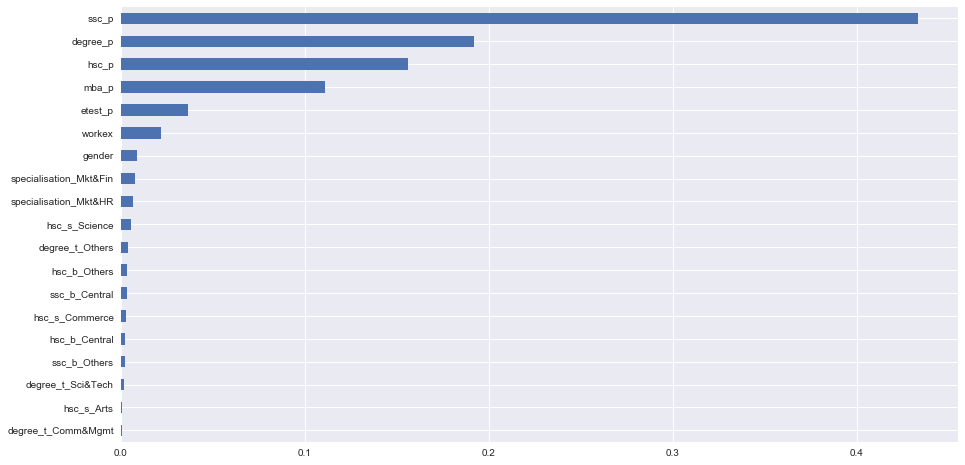

In [22]:
feature_importance = pd.Series(rf_regressor.feature_importances_,index=x.columns)
feature_importance = feature_importance.sort_values()
feature_importance.plot(kind='barh')

After we train the initial regressor, we proceed with parameter tunning to try and find the optimized value for

- `n_estimators`: The number of trees in the forest
- `max_features`: The number of features to consider when looking for the best split
- `min_samples_leaf`: The minimum number of samples required to be at a leaf node

By inputting different values or methods, we will try and find out the value that provides the highest score.

30  trees
0.9282329988851727

50  trees
0.934757525083612

100  trees
0.9364538043478261

200  trees
0.9384769544314381

500  trees
0.9381707775919732

1000  trees
0.9368050689799331

2000  trees
0.937170795882107



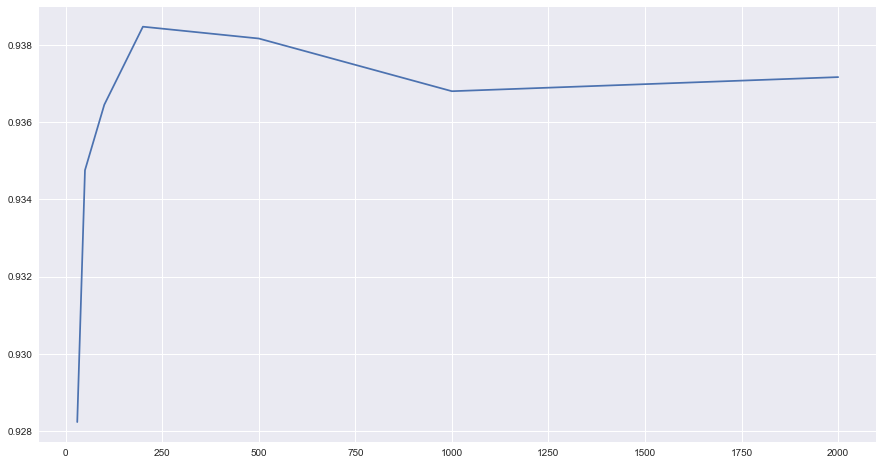

In [23]:
# parameter tunning
# # of trees trained parameter tunning

results = []
n_estimator_options = [30,50,100,200,500,1000,2000]

for trees in n_estimator_options:
    model = RandomForestRegressor(trees,oob_score=True,n_jobs=-1,random_state=42)
    model.fit(x,y)
    print(trees," trees")
    score = model.score(train_x,train_y)
    print(score)
    results.append(score)
    print("")

pd.Series(results,n_estimator_options).plot()

auto  option
0.9384769544314381

None  option
0.9384769544314381

sqrt  option
0.9390570129598662

log2  option
0.9390570129598662

0.9  option
0.9369554765886288

0.2  option
0.933998745819398



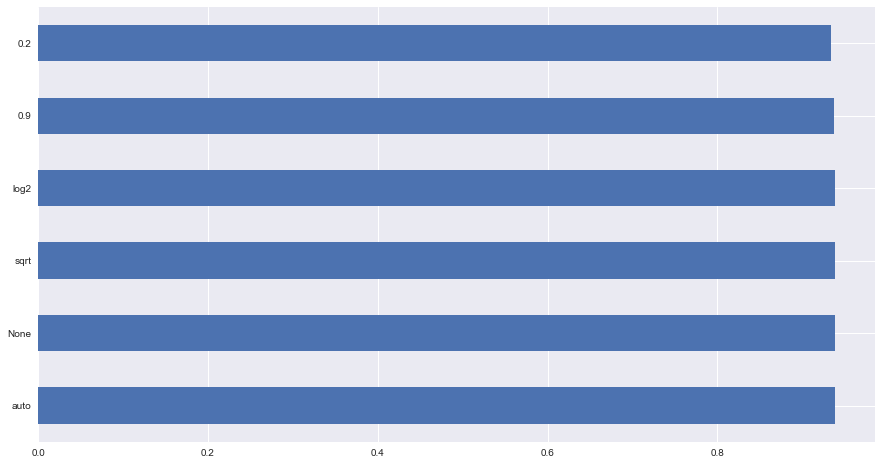

In [24]:
# max number of features parameter tunning
results = []
max_features_options = ['auto',None,'sqrt','log2',0.9,0.2]

for max_features in max_features_options:
    model = RandomForestRegressor(n_estimators=200,oob_score=True,n_jobs=-1,
                                  random_state=42,max_features=max_features)
    model.fit(x,y)
    print(max_features," option")
    score = model.score(train_x,train_y)
    print(score)
    results.append(score)
    print("")

pd.Series(results,max_features_options).plot(kind='barh')

1  min samples
0.9390570129598662

2  min samples
0.8468437412943985

3  min samples
0.7849329211313523

4  min samples
0.7429301237527113

5  min samples
0.7036783300373053

6  min samples
0.6768184101753145

7  min samples
0.6556513671298129

8  min samples
0.6392326149831353

9  min samples
0.6179466096568267

10  min samples
0.601184726503665



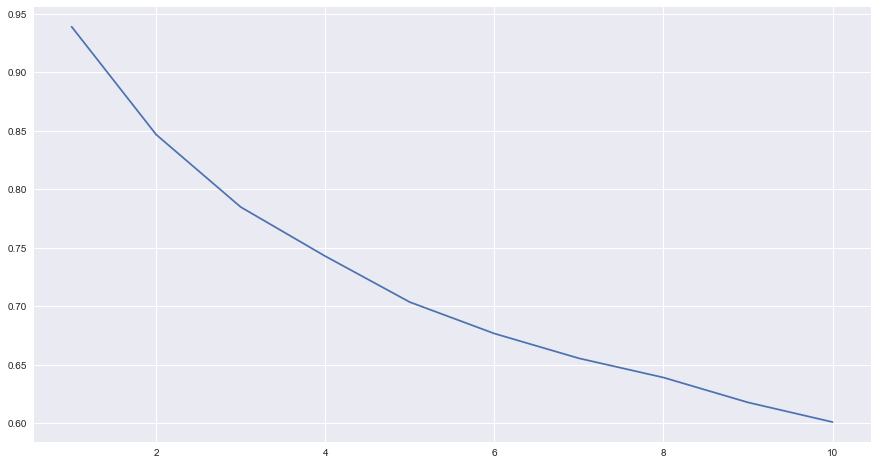

In [25]:
# min sample leaf parameter tunning
results = []
min_sample_leaf_option = [1,2,3,4,5,6,7,8,9,10]

for min_sample_leaf in min_sample_leaf_option:
    model = RandomForestRegressor(n_estimators=200,oob_score=True,n_jobs=-1,
                                  random_state=42,max_features='sqrt',
                                  min_samples_leaf=min_sample_leaf)
    model.fit(x,y)
    print(min_sample_leaf," min samples")
    score = model.score(train_x,train_y)
    print(score)
    results.append(score)
    print("")

pd.Series(results,min_sample_leaf_option).plot()

After the analysis above, the parameter we're choosing for each of the parameter are:

- `n_estimators`: 200
- `max_features`: sqrt
- `min_samples_leaf`: 1

And by inputting these new values, we got a better model with a slightly higher model score.

In [26]:
rf_regressor = RandomForestRegressor(200, oob_score=True,max_features='sqrt',
                                     n_jobs=-1, random_state=42,min_samples_leaf=1)
rf_regressor.fit(x,y)
print('Score: ', rf_regressor.score(train_x,train_y))

Score:  0.9390570129598662


Just to see how good the model performs, we compared the top 10 value from the test dataset and also the predicted probability from the model. We can see that most of the prediction is accurate

In [27]:
pred_y = rf_regressor.predict(test_x)

print(test_y[:10])
print(pred_y[:10])

200    1.0
212    1.0
138    1.0
176    1.0
15     1.0
111    0.0
168    0.0
73     1.0
204    1.0
139    1.0
Name: status, dtype: float64
[0.955 0.955 0.98  0.785 0.995 0.055 0.06  0.95  0.995 0.945]


Similarly, then we train a Random Forest Classifier to see how the data perform with a classifier using the same parameters we got from the regressor.
The model score is 0.8 and from the confusion matric, we can see that the classifier do a better job in correctly predicting student being placed a job then not being placed a job, as only 2 were misclassified into not placed while 10 were misclassified into placed.

In [28]:
rf_classifier = RandomForestClassifier(200, oob_score=True,
                                     n_jobs=-1, random_state=42)
rf_classifier.fit(train_x, train_y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

In [29]:
pred_y = rf_classifier.predict(test_x)

In [30]:
rf_classifier.score(test_x, test_y)

0.8

Text(316.06, 0.5, 'true value')

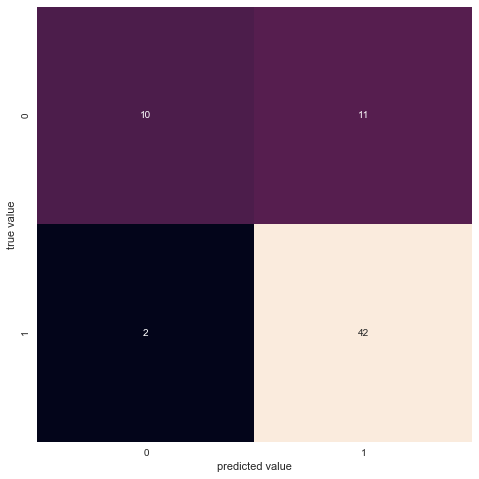

In [31]:
mat = confusion_matrix(test_y,pred_y)
sns.heatmap(mat, square=True, annot=True, cbar=False) 
plt.xlabel('predicted value')
plt.ylabel('true value')

In [32]:
print(classification_report(test_y, pred_y))

              precision    recall  f1-score   support

         0.0       0.83      0.48      0.61        21
         1.0       0.79      0.95      0.87        44

    accuracy                           0.80        65
   macro avg       0.81      0.72      0.74        65
weighted avg       0.81      0.80      0.78        65



### Logistic Regression Classifier

We want to fit the data with different type of classifiers to see which classifier works best for this dataset. The second classifier used is Logistic Regression.

Following the same step of fitting the model and making prediction from the test data. Logistic regression have a model score of 0.84, which is slightly higher than the Random Forest Classifier. And from the confusion matrix, it performed better in classifying not placed students than Random Forest.

In [33]:
lr_model = LogisticRegression()
lr_model.fit(train_x,train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [34]:
lr_model.score(test_x, test_y)

0.8461538461538461

Text(316.06, 0.5, 'true value')

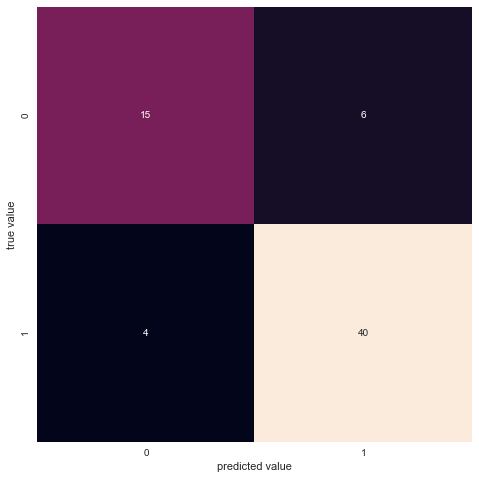

In [35]:
pred_y = lr_model.predict(test_x)
mat = confusion_matrix(test_y,pred_y)
sns.heatmap(mat, square=True, annot=True, cbar=False) 
plt.xlabel('predicted value')
plt.ylabel('true value')

In [36]:
print(classification_report(test_y, pred_y))

              precision    recall  f1-score   support

         0.0       0.79      0.71      0.75        21
         1.0       0.87      0.91      0.89        44

    accuracy                           0.85        65
   macro avg       0.83      0.81      0.82        65
weighted avg       0.84      0.85      0.84        65



We've also print out the coefficients of the model and plot them on a barplot. The most important factors are previous work experience of the student.

In [37]:
lr_coef = pd.DataFrame({"Coefficients":lr_model.coef_[0]},index = x.columns.tolist())
lr_coef = lr_coef.sort_values(by = 'Coefficients')
lr_coef

,Coefficients
degree_t_Others,-0.793095
specialisation_Mkt&HR,-0.775287
hsc_b_Others,-0.510346
ssc_b_Central,-0.502368
hsc_s_Commerce,-0.471134
mba_p,-0.323843
hsc_s_Science,-0.317995
ssc_b_Others,-0.302052
hsc_b_Central,-0.294075
degree_t_Sci&Tech,-0.145726


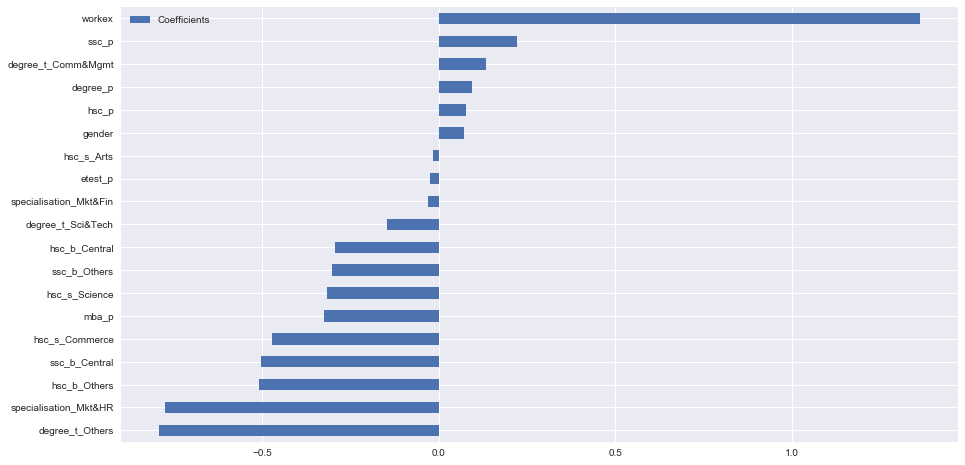

In [38]:
lr_coef.plot(kind='barh')

## Regression

The second purpose of this analysis is the find out the important factors that influenced students' salary. For this analysis, we are using the **recruit_placed** dataset.

In [39]:
recruit_placed.head()

,gender,ssc_p,hsc_p,degree_p,workex,etest_p,mba_p,salary,ssc_b_Central,ssc_b_Others,hsc_b_Central,hsc_b_Others,hsc_s_Arts,hsc_s_Commerce,hsc_s_Science,degree_t_Comm&Mgmt,degree_t_Others,degree_t_Sci&Tech,specialisation_Mkt&Fin,specialisation_Mkt&HR
0,1,67.00,91.00,58.00,0,55.0,58.80,270000.0,0,1,0,1,0,1,0,0,0,1,0,1
1,1,79.33,78.33,77.48,1,86.5,66.28,200000.0,1,0,0,1,0,0,1,0,0,1,1,0
2,1,65.00,68.00,64.00,0,75.0,57.80,250000.0,1,0,1,0,1,0,0,1,0,0,1,0
4,1,85.80,73.60,73.30,0,96.8,55.50,425000.0,1,0,1,0,0,1,0,1,0,0,1,0
7,1,82.00,64.00,66.00,1,67.0,62.14,252000.0,1,0,1,0,0,0,1,0,0,1,1,0


We first plot the pairplot to examine the correlation between different variables and print out the correlation matrix.

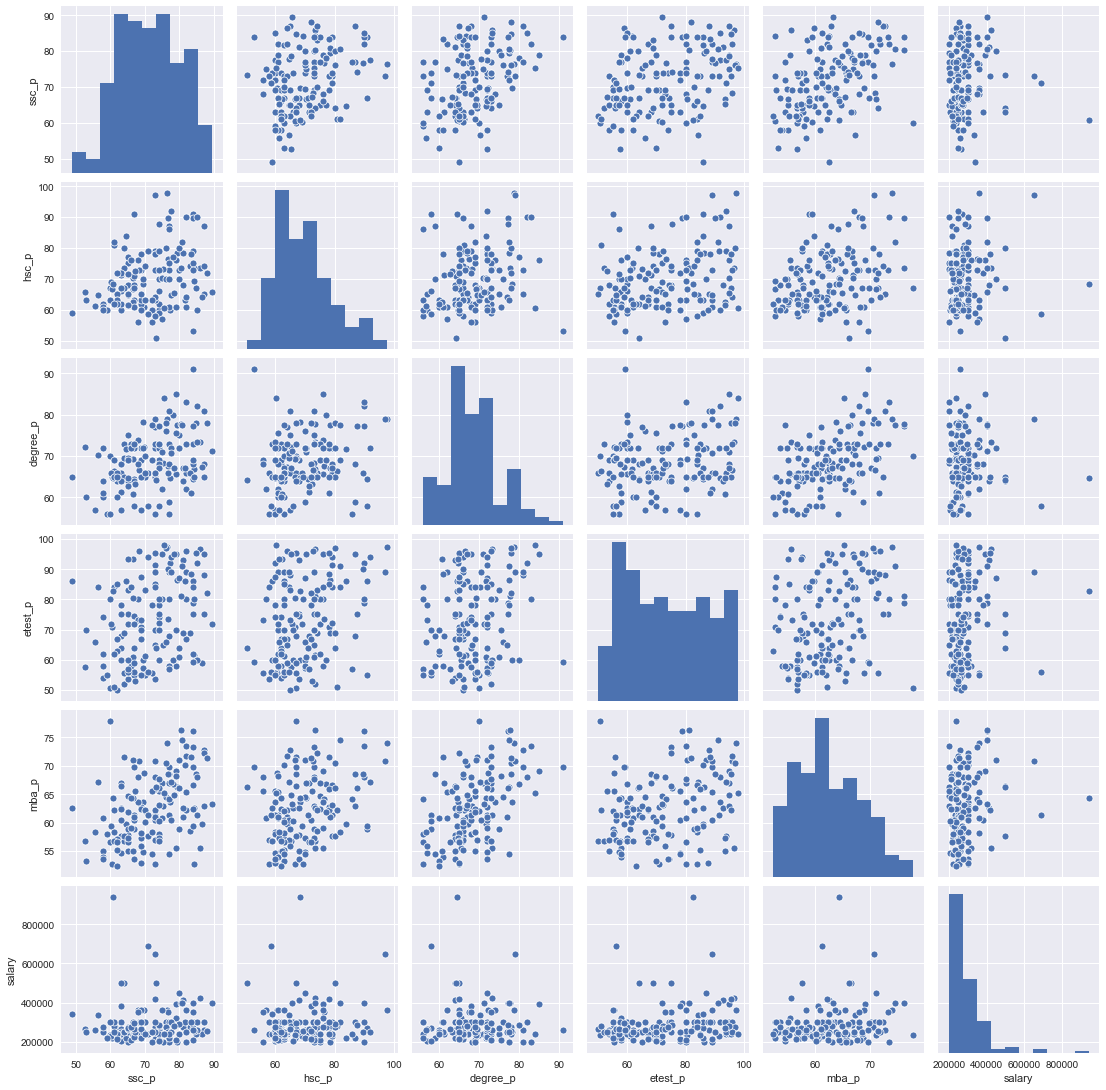

In [40]:
sns.pairplot(recruit_placed[['ssc_p','hsc_p','degree_p','etest_p','mba_p','salary']])

In [41]:
recruit_placed[['ssc_p','hsc_p','degree_p','etest_p','mba_p','salary']].corr()

,ssc_p,hsc_p,degree_p,etest_p,mba_p,salary
ssc_p,1.000000,0.293416,0.380657,0.317892,0.430560,0.035330
hsc_p,0.293416,1.000000,0.221307,0.284672,0.329983,0.076819
degree_p,0.380657,0.221307,1.000000,0.217683,0.494093,-0.019272
etest_p,0.317892,0.284672,0.217683,1.000000,0.284143,0.178307
mba_p,0.430560,0.329983,0.494093,0.284143,1.000000,0.175013
salary,0.035330,0.076819,-0.019272,0.178307,0.175013,1.000000


W've selected the following variables for the linear regression.

In [42]:
var = ['ssc_p','hsc_p','degree_p','etest_p','mba_p','gender','workex']
x = recruit_placed.loc[:,var]
# x = recruit_placed.loc[:,recruit_placed.columns != 'salary']
y = recruit_placed.loc[:,recruit_placed.columns == 'salary']
x.head()

,ssc_p,hsc_p,degree_p,etest_p,mba_p,gender,workex
0,67.00,91.00,58.00,55.0,58.80,1,0
1,79.33,78.33,77.48,86.5,66.28,1,1
2,65.00,68.00,64.00,75.0,57.80,1,0
4,85.80,73.60,73.30,96.8,55.50,1,0
7,82.00,64.00,66.00,67.0,62.14,1,1


In [43]:
train_x, test_x, train_y, test_y = train_test_split(x,y , test_size=0.2, random_state=42)

print(train_x.shape)
print(test_x.shape)

(118, 7)
(30, 7)


For linear regression, we are using `OLS` from `statsmodel` package. The model has a R square of 0.91. The variables that have the highest influence are:

- gender (positive)
- workex (positive)
- degree_p (negative)
- ssc_p (negative)

In [44]:
linear_model = sm.OLS(train_y,train_x.astype(float))
results = linear_model.fit()
results.params

ssc_p        -666.957153
hsc_p        -506.035324
degree_p    -1280.182938
etest_p       586.402174
mba_p        6072.172635
gender      47362.574736
workex      11613.514268
dtype: float64

In [45]:
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                 salary   R-squared (uncentered):                   0.914
Model:                            OLS   Adj. R-squared (uncentered):              0.908
Method:                 Least Squares   F-statistic:                              168.1
Date:                Tue, 23 Jun 2020   Prob (F-statistic):                    4.94e-56
Time:                        22:42:13   Log-Likelihood:                         -1511.6
No. Observations:                 118   AIC:                                      3037.
Df Residuals:                     111   BIC:                                      3057.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Print out the prediction and compare them with the test dataset, we can see that some of the prediction are close, but the model definitely needs further fine tunning.

In [46]:
pred_y = results.predict(test_x)
# print(pred_y[:10])
# print(test_y[:10])

col = ['actual','prediction']

prediction = pd.concat([test_y,pred_y],axis=1)
prediction.columns = col
prediction

,actual,prediction
178,350000.0,342759
74,336000.0,344419
203,260000.0,299097
28,350000.0,315199
145,400000.0,289462
20,265000.0,262239
112,250000.0,261264
48,250000.0,303715
117,240000.0,318652
15,200000.0,276824


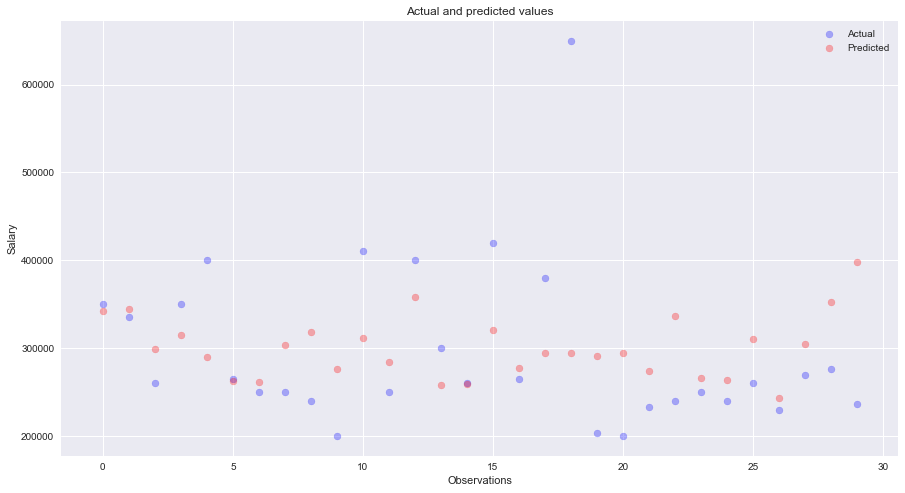

In [47]:
_, ax = plt.subplots()

ax.scatter(x = range(0, test_y.size), y=test_y, c = 'blue', label = 'Actual', alpha = 0.3)
ax.scatter(x = range(0, pred_y.size), y=pred_y, c = 'red', label = 'Predicted', alpha = 0.3)

plt.title('Actual and predicted values')
plt.xlabel('Observations')
plt.ylabel('Salary')
plt.legend()
plt.show()